In [1]:
import numpy as np
import tensorflow as tf
tf.__version__

'0.12.0'

In [2]:
#dependencies (numpy, matplotlib, and keras)
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

Using TensorFlow backend.


In [3]:
#hyperparameters
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 5
epsilon_std = 1.0

In [4]:
#encoder
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

print(z_mean)
print(z_log_var)

Tensor("add_1:0", shape=(100, 2), dtype=float32)
Tensor("add_2:0", shape=(100, 2), dtype=float32)


In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var/2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

print(z)

Tensor("add_3:0", shape=(100, 2), dtype=float32)


In [6]:
#decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

print(x_decoded_mean)

Tensor("Sigmoid:0", shape=(100, 784), dtype=float32)


In [7]:

#loss
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
       shuffle=True,
       nb_epoch=nb_epoch,
       batch_size=batch_size,
       validation_data=(x_test, x_test), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 13s - loss: 192.2474 - val_loss: 172.0908
Epoch 2/5
60000/60000 [==============================] - 13s - loss: 169.6816 - val_loss: 167.4340
Epoch 3/5
60000/60000 [==============================] - 13s - loss: 166.3520 - val_loss: 165.5571
Epoch 4/5
60000/60000 [==============================] - 13s - loss: 164.4080 - val_loss: 163.5771
Epoch 5/5
60000/60000 [==============================] - 14s - loss: 162.9746 - val_loss: 162.6463


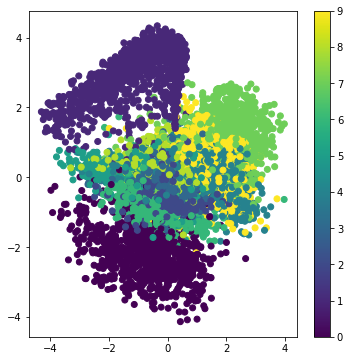

In [11]:
##plot latent/hidden space

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
encoder.compile(optimizer='rmsprop', loss=vae_loss)
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

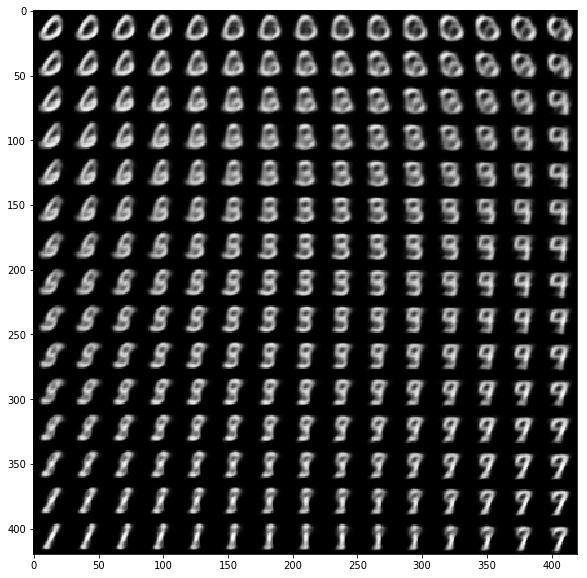

In [17]:
#builg a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)
generator.compile(optimizer='rmsprop', loss=vae_loss)
#display a 2D manifold of the digits
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

#linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf)
#of the Gaussian
#to produce values of the latent variables, z
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size:(i+1)*digit_size,
               j * digit_size:(j+1)*digit_size] = digit
        
        
plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [18]:
import keras as kr
kr.__version__

'1.0.0'